In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
def simulate_xt(x0, t):
    t = t.view(-1, 1)
    m_t = torch.exp(-t)
    sigma_t = torch.sqrt(1 - torch.exp(-2 * t))
    z = torch.randn_like(x0)
    xt = m_t * x0 + sigma_t * z
    return xt, z, m_t, sigma_t

In [3]:
N_SAMPLES = 100_000

In [4]:
def generate_exp_data(lam=2.0, n_samples=100_000, device='cpu'):
    d = 2
    x0 = torch.distributions.Exponential(rate=lam).sample((n_samples, d)).to(device)
    t = torch.rand(n_samples, 1, device=device) * 6.0
    m_t = torch.exp(-t)
    z = torch.randn(n_samples, d, device=device)
    xt = m_t * x0 + torch.sqrt(1 - m_t**2) * z

    return x0, t, z, xt

In [5]:
device = "cpu"

In [6]:
class ScoreNet(nn.Module):
    def __init__(self, d=2, N=128, activation='relu'):
        super().__init__()
        self.N = N
        self.d = d
        self.input_dim = d + 1

        self.w = nn.Parameter(torch.randn(N, self.input_dim))
        self.b = nn.Parameter(torch.randn(N))
        self.a = nn.Parameter(torch.randn(N, d))

        if activation == 'relu':
            self.activation = torch.relu
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        else:
            raise ValueError("Unknown activation")

    def forward(self, t, x):
        if t.dim() == 1:
            t = t.unsqueeze(1)
        x_input = torch.cat([x, t], dim=1)

        B = x_input.shape[0]

        x_exp = x_input.unsqueeze(1)
        w_exp = self.w.unsqueeze(0)
        b_exp = self.b.unsqueeze(0).unsqueeze(-1)
        a_exp = self.a.unsqueeze(0)

        inner = torch.sum(w_exp * x_exp, dim=-1, keepdim=True)
        h = self.activation(inner + b_exp)
        contrib = h * a_exp

        return contrib.mean(dim=1)

In [7]:
import torch.nn as nn

class ScoreNet(nn.Module):
    def __init__(self, d=2, hidden_dim=64):
        super().__init__()
        input_dim = d + 1

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, d)
        )


    def forward(self, t, x):
        if t.dim() == 1:
            t = t.unsqueeze(1)
        x_in = torch.cat([x, t], dim=1)
        return self.net(x_in)


In [8]:
def compute_H(net, x0, t, z):
    B, d = x0.shape
    m_t = torch.exp(-t)
    sigma_t = torch.sqrt(1 - torch.exp(-2 * t))
    kappa_t = sigma_t ** 2
    x_t = m_t * x0 + sigma_t * z
    x_t.requires_grad_(True)

    s = net(t, x_t)

    total_grad = [torch.zeros_like(p) for p in net.parameters()]

    for i in range(B):
        x_i = x_t[i].view(1, -1).clone().detach().requires_grad_(True)
        t_i = t[i].view(1, 1)
        z_i = z[i]

        s_i = net(t_i, x_i)[0]

        sigma_inv_z = z_i / sigma_t[i]
        coeff = sigma_inv_z + s_i

        for j in range(d):
            grad_sij = torch.autograd.grad(
                outputs=s_i[j],
                inputs=list(net.parameters()),
                retain_graph=True,
                create_graph=True,
                allow_unused=True
            )

            for k in range(len(total_grad)):
                if grad_sij[k] is not None:
                    total_grad[k] += 2 * kappa_t[i, 0] * coeff[j] * grad_sij[k]

    return total_grad

In [9]:
def sgld_update(params, grads, lr, beta):
    updated = []
    for p, g in zip(params, grads):
        noise = torch.randn_like(p)
        noise_scale = (2 * lr / beta) ** 0.5
        p_new = p - lr * g + noise_scale * noise
        updated.append(p_new)
    return updated

In [10]:
net = ScoreNet()
net.train()

ScoreNet(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = ScoreNet(d=2).to(device)
B, d = 32, 2
lr = 1e-3
beta = 10**8
num_steps = 30000
grad_norms = []

In [12]:
best_H = float('inf')
theta_hat_best = None
theta_trajectory = []

for step in range(num_steps):
    x0, t, z, xt = generate_exp_data(lam=2.0, n_samples=B, device=device)
    grads = compute_H(net, x0, t, z)
    grad_norm = torch.sqrt(sum(g.norm()**2 for g in grads if g is not None))
    grad_norms.append(grad_norm.item())
    updated_params = sgld_update(list(net.parameters()), grads, lr, beta)

    with torch.no_grad():
        for p, new_p in zip(net.parameters(), updated_params):
            p.copy_(new_p)

        H_value = sum((g**2).sum().item() for g in grads if g is not None)

        if H_value < best_H:
            best_H = H_value
            theta_hat_best = {
                name: p.detach().clone().cpu()
                for name, p in net.named_parameters()
            }

        theta = torch.cat([p.flatten() for p in net.parameters()])
        theta_trajectory.append(theta.cpu().numpy())


In [13]:
for name, p in net.named_parameters():
    print(name, torch.norm(p).item())

net.0.weight 5.193717002868652
net.0.bias 2.7305212020874023
net.2.weight 5.35426139831543
net.2.bias 0.563279926776886
net.4.weight 5.242175579071045
net.4.bias 0.8146059513092041
net.6.weight 2.409318447113037
net.6.bias 0.11120032519102097


In [14]:
with torch.no_grad():
    for name, p in net.named_parameters():
        p.copy_(theta_hat_best[name].to(p.device))

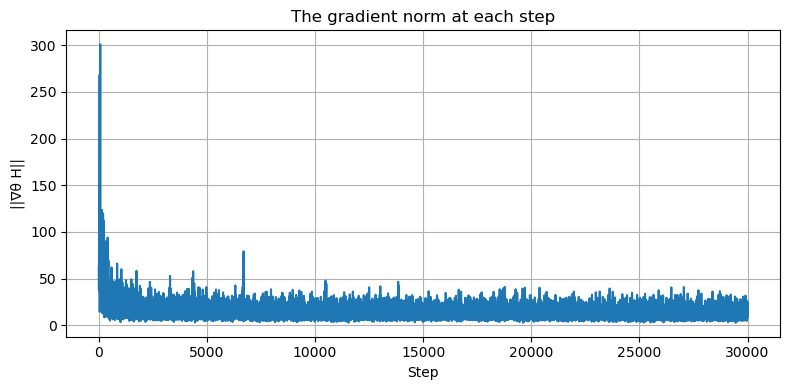

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(grad_norms)
plt.title("The gradient norm at each step")
plt.xlabel("Step")
plt.ylabel("||∇θ H||")
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
import numpy as np

N_samples = 5000
dim = 2
gamma = 1e-5
K = 5000
T = 3.0
timesteps = np.linspace(0, T, K + 1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lam = 2.0
x0 = torch.distributions.Exponential(rate=lam).sample((N_samples, dim)).to(device)
z = torch.randn(N_samples, dim).to(device)

t_T = torch.tensor([T], device=device)
m_T = torch.exp(-t_T)
sigma_T = torch.sqrt(1 - torch.exp(-2 * t_T))

Y = m_T * x0 + sigma_T * z

for k in tqdm(range(K)):
    t_k = timesteps[k]
    tau = torch.tensor([T - t_k], device=device, dtype=torch.float32)
    tau_batch = tau.expand(N_samples, 1)

    with torch.no_grad():
        s_val = net(tau_batch, Y)

    drift = - 2 * s_val
    noise = torch.randn_like(Y)
    Y = Y + gamma * drift + torch.sqrt(torch.tensor(2 * gamma)) * noise
    Y = torch.clamp(Y, min=0.0)

samples = Y.detach().cpu().numpy()


  0%|          | 0/5000 [00:00<?, ?it/s]

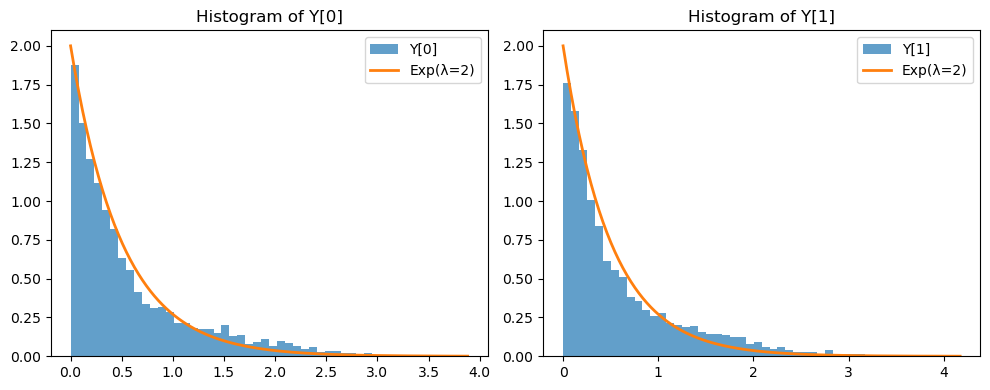

In [17]:
from scipy.stats import expon

plt.figure(figsize=(10, 4))
for i in range(dim):
    plt.subplot(1, dim, i+1)
    plt.hist(samples[:, i], bins=50, density=True, alpha=0.7, label=f"Y[{i}]")

    lambda_ = 2.0
    x_vals = np.linspace(0, samples[:, i].max(), 200)
    plt.plot(x_vals, expon(scale=1/lambda_).pdf(x_vals), label="Exp(λ=2)", lw=2)

    plt.title(f"Histogram of Y[{i}]")
    plt.legend()

plt.tight_layout()
plt.show()
